In [1]:
#!/usr/bin/env python2

# Eilon Sharon May 2016

%matplotlib inline

from __future__ import division

import sys
import os

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#matplotlib.style.use('ggplot')
from scipy.stats import kendalltau
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from scipy.stats import gaussian_kde

import random

from Bio import SeqIO
from Bio.Seq import Seq
from Bio.Alphabet import generic_dna
from Bio import pairwise2

import seaborn as sns
sns.set(rc={"figure.figsize": (6, 6)})



sys.path.append(os.path.expanduser('~/bin/python/crispr'))
from crispr_draw_func import draw_design_stats








/Users/eilon/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
###############################################################################################################
# input parameters
###############################################################################################################

#lib_name = 'pol2_V8'
#lib_name = 'pol3_V8'
#lib_name = 'noPol_V8'
lib_name = 'bothPolForGeneNonForSNP_V2'

guide_length = 20
edit_max_distance_from_PAM5prime = 17

PAM_seq = 'GG' # pam_seqs[0] 
# the code for desinging guides for SNPs supports multiple PAM sequences
# pam_seqs = [PAM_seq] # ["GG"]





agilent_homopolymer_max_len = 10


excluded_seqs_pol2 = ['TATATA','TATGTA', 'A' * agilent_homopolymer_max_len, 'C' * agilent_homopolymer_max_len, 'G' * agilent_homopolymer_max_len, 'T' * agilent_homopolymer_max_len]
excluded_seqs_pol3 = ['TTTTT', 'A' * agilent_homopolymer_max_len, 'C' * agilent_homopolymer_max_len, 'G' * agilent_homopolymer_max_len, 'T' * agilent_homopolymer_max_len]
excluded_seqs_noPol = ['A' * agilent_homopolymer_max_len, 'C' * agilent_homopolymer_max_len, 'G' * agilent_homopolymer_max_len, 'T' * agilent_homopolymer_max_len]
excluded_seqs_bothPol = ['TTTTT','TATATA','TATGTA', 'A' * agilent_homopolymer_max_len, 'C' * agilent_homopolymer_max_len, 'G' * agilent_homopolymer_max_len, 'T' * agilent_homopolymer_max_len]

excluded_seqs_SNPs = []
excluded_seqs_Genes = []
if lib_name.startswith('pol2'):    # (lib_name in  ['pol2']):
    excluded_seqs_SNPs = excluded_seqs_pol2
    excluded_seqs_Genes = excluded_seqs_pol2
elif lib_name.startswith('pol3'):  #(lib_name in  ['pol3']):
    excluded_seqs_SNPs = excluded_seqs_pol3
    excluded_seqs_Genes = excluded_seqs_pol3
elif lib_name.startswith('noPol'):  #(lib_name in  ['noPol']):
    excluded_seqs_SNPs = excluded_seqs_noPol
    excluded_seqs_Genes = excluded_seqs_noPol
elif lib_name.startswith('bothPolForGeneNonForSNP'):  #(lib_name in  ['noPol']):
    excluded_seqs_SNPs = excluded_seqs_noPol
    excluded_seqs_Genes = excluded_seqs_bothPol
else:
    raise ValueError('Unknown excluded sequences for the library name: %s' % (lib_name))
  


donor_length = 100
min_dist_cut_to_donor_edge = 30

BOWTIE_exe = "/Users/eilon/software/bowtie2-2.2.8/bowtie2"
#BOWTIE_exe = "bowtie2"

design_guide_for_dubious_gene_in_qtls_flag = False
design_guide_for_essential_dubious_genes_flag = False

min_ok_Azimuth_score_guides_in_genes = 0.5
min_ok_Azimuth_score_SNP_guides = 0

off_targets_min_mismatch_gene_guides = 10
off_targets_min_mismatch_SNP_guides = 1

max_num_of_essential_genes_to_select = 100
qtl_trait_for_essential_genes = ['YPD']

# for guides in essential genes
max_guide_pos_frac_in_gene_essential = 0.66

# for 1bpMut
K_donors_for_each_guide_pos_1bpMut = 100
max_guide_pos_frac_in_gene_1bpMut = 0.53

oligo_production_batch_size = 2000



###############################################################################################################

# directories
working_dir = "/Users/eilon/Dropbox/postdoc/crispr"
output_directory = working_dir + "/Output"
output_lib_dir = output_directory + "/lib_design"
output_fig_dir = output_lib_dir + "/Figures"

input_directory = working_dir + "/Input"
lib_design_input_dir = input_directory + "/lib_design"
input_Bloom_dir = input_directory + "/Bloom"

os.chdir(working_dir)
print "Current directory: %s" % os.getcwd()

###############################################################################################################

# input files

# from Carlo's analysis
input_by_rm_snps_vcf = working_dir + "/01-GATK_Bloom_RM_Data/GATK_RM_Vars_SCC30SEC10_LowQualFilt_141022.vcf"

# http://downloads.yeastgenome.org/sequence/S288C_reference/genome_releases/
input_genome_fasta_filename = working_dir + "/01-GATK_Bloom_RM_Data/S288C_R64_REAN_140405.fa"


# annotations files are from # http://downloads.yeastgenome.org/sequence/S288C_reference/genome_releases/ 
# version 61_1_1
# cat Input/S288C_reference_genome_R64-1-1_20110203/saccharomyces_cerevisiae_R64-1-1_20110208.gff |  head -n 16425 > Input/S288C_reference_genome_R64-1-1_20110203/saccharomyces_cerevisiae_R64-1-1_20110208_noFasta.gff
input_annot_gff_filename = input_directory + "/S288C_reference_genome_R64-1-1_20110203/saccharomyces_cerevisiae_R64-1-1_20110208_noFasta.gff"


#####################################################
# input - essential genes
#####################################################
# esential genes used to be from:
# http://www-sequence.stanford.edu/group/yeast_deletion_project/Essential_ORFs.txt
# essential_genes_filename = os.path.expanduser("~/Dropbox/postdoc/crispr/Input/essential/crispr_analyze_guides.txt")
# replaced by: http://www.yeastgenome.org/phenotype/inviable/overview

essential_genes_filename = input_directory +  "/essential/inviable_annotations.txt"


#####################################################
# input - Bloom QTL
#####################################################

input_known_genes_with_large_effect = input_directory + "/gene_with_known_large_effect.txt"

# selected 8 bloom QTL
input_bloom_selected_QTLs =  lib_design_input_dir + "/selected_bloom_traits.txt"

input_QTLs_filename   = input_Bloom_dir + "/nature11867-s4.csv"
input_QTLs_H_filename = input_Bloom_dir + "/nature11867-s2.txt"


#####################################################
# donor design for SNPs
#####################################################

# SNP guides donor design table 
input_SNP_donor_design_table_filename = lib_design_input_dir + "/design_donor_for_snps.txt"

#####################################################
# guide and donor design table for genes- selected QTL and essential genes in selected QTL 
#####################################################

# design table for QTL genes
input_qtl_gene_design_table_filename = lib_design_input_dir + "/design_guides_in_qtl_genes.txt"

# desing table for essential genes
input_guide_design_cols_for_essential_genes_filename = lib_design_input_dir + "/design_guides_in_essential_genes.txt"

# desing table for essential genes 1bpMut
input_guide_design_cols_for_essential_genes_1bpMut_filename = lib_design_input_dir + "/design_guides_in_essential_genes_1bpMut.txt"

# desing table for essential genes stop2aa
input_guide_design_cols_for_essential_genes_stop2aa_filename = lib_design_input_dir + "/design_guides_in_essential_genes_stop2aa.txt"


#####################################################
# oligo design table - contains information about the other segments in the oligo 
#####################################################

input_oligo_design_table_filename = lib_design_input_dir + "/oligo_design_table.txt"

#####################################################
# spliting the oligo into files by sets 
#####################################################

input_sets_by_priority_filename = lib_design_input_dir + "/sets_by_priority.txt"


###############################################################################################################
# output files (no need to pass as argument -  depends on the output directory, PAM sequence and max edit distance)
###############################################################################################################

output_files_uniq_str = lib_name + "_" + PAM_seq + "_" + str(edit_max_distance_from_PAM5prime) + "bp"


# log
output_log_stdout_filename = output_lib_dir + "/log_" + output_files_uniq_str + "_stdout.txt"
output_log_stderr_filename = output_lib_dir + "/log_" + output_files_uniq_str + "_stderr.txt"

################ genes in SNPs

# step: extract all guides for SNPs
output_SNP_table_filename =    output_lib_dir + "/all_SNPs_" + output_files_uniq_str + "_SNP.tab"
output_guides_table_filename = output_lib_dir + "/all_SNPs_" + output_files_uniq_str + "_GUIDE.tab"

# step: calculate features for SNPs
output_guides_with_features_table_filename = output_lib_dir + "/all_SNPs_" + output_files_uniq_str + "_GUIDE_withFeatures.tab"

# step: design SNP donor sequences
output_SNP_donor_table_filename = output_lib_dir + "/all_SNPs_" + output_files_uniq_str + "_DONOR.tab"

# step: rank guides for each SNP and add pass filter column
output_guides_with_features_and_rank_table_filename = output_lib_dir + "/all_SNPs_" + output_files_uniq_str + "_GUIDE_withFeatures_withRank.tab"


# step: merge SNPs with Bloom QTLs
output_selected_qtls_table_filename = output_lib_dir + "/selected_QTLs_" + output_files_uniq_str + ".tab"
output_SNP_merged_with_QTL_table_filename = output_lib_dir + "/all_SNPs_" + output_files_uniq_str + "_SNP_merged_with_QTL.tab"
output_SNP_withQTL_table_filename = output_lib_dir + "/all_SNPs_" + output_files_uniq_str + "_SNP_withQTL.tab"
output_snp_in_selected_QTLs_filename = output_lib_dir + "/SNPs_in_selected_QTLs_" + output_files_uniq_str + ".tab"

# step: create oligos from guide and donor tables for SNPs
output_oligos_for_SNPs_in_selected_qtls_df_filename = output_lib_dir + "/all_SNPs_in_selected_QTLs_" + output_files_uniq_str + "_OLIGO.tab"
output_oligos_for_SNPs_not_in_selected_qtls_df_filename = output_lib_dir + "/all_SNPs_not_in_selected_QTLs_" + output_files_uniq_str + "_OLIGO.tab"

################ genes in QTLs 


# step: generate design table for genes in QTLs
output_qtl_uniq_gene_guides_design_table_filename = output_lib_dir + "/design_guides_in_selected_qtl_genes_uniq_" + output_files_uniq_str + ".tab"
output_qtl_nonuniq_gene_guides_design_table_filename = output_lib_dir + "/design_guides_in_selected_qtl_genes_nonuniq_" + output_files_uniq_str + ".tab"
output_qtl_genes_that_were_filtered_out_filename = output_lib_dir + "/genes_in_qtls_that_were_filtered_out_" + output_files_uniq_str + ".tab"

# step: designing guides and donors for genes in QTLs
output_guides_for_genes_in_QTLs_df_filename = output_lib_dir + "/selected_QTL_genes_" + output_files_uniq_str + "_GUIDE.tab"
output_donors_for_genes_in_QTLs_df_filename = output_lib_dir + "/selected_QTL_genes_" + output_files_uniq_str + "_DONOR.tab"

# step: create oligos from guide and donor tables for Genes in QTL
output_oligos_for_genes_in_selected_qtls_df_filename= output_lib_dir + "/selected_QTL_genes_" + output_files_uniq_str + "_OLIGO.tab"

################ essential overlap with eql - for part of the edits

# step: create design table for guides and donors in essential genes by loading the genes and merging with the design table 
output_essential_gene_design_table_filename = output_lib_dir + "/essential_genes_design_table_" + output_files_uniq_str + ".tab"

# step designing guides and donors for genes in QTLs
output_guides_for_essential_genes_df_filename = output_lib_dir + "/essential_genes_" + output_files_uniq_str + "_GUIDE.tab"
output_donors_for_essential_genes_df_filename = output_lib_dir + "/essential_genes_" + output_files_uniq_str + "_DONOR.tab"
output_oligos_for_essential_genes_df_filename= output_lib_dir + "/essential_genes_" + output_files_uniq_str + "_OLIGO.tab"

# step: create design table for guides and donors in essential genes by loading the genes and merging with the design table 
output_essential_gene_1bpMut_design_table_filename = output_lib_dir + "/essential_genes_1bpMut_design_table.tab"

# step designing guides and donors for genes in QTLs
output_guides_for_essential_genes_1bpMut_df_filename = output_lib_dir + "/essential_genes_1bpMut_" + output_files_uniq_str + "_GUIDE.tab"
output_donors_for_essential_genes_1bpMut_unfiltered_df_filename = output_lib_dir + "/essential_genes_1bpMut_" + output_files_uniq_str + "_unfilt_DONOR.tab"
output_donors_for_essential_genes_1bpMut_df_filename = output_lib_dir + "/essential_genes_1bpMut_" + output_files_uniq_str + "_DONOR.tab"
output_oligos_for_essential_genes_1bpMut_df_filename= output_lib_dir + "/essential_genes_1bpMut_" + output_files_uniq_str + "_OLIGO.tab"

# step: create design table for guides and donors in essential genes by loading the genes and merging with the design table 
output_essential_gene_stop2aa_design_table_filename = output_lib_dir + "/essential_genes_stop2aa_design_table_" + output_files_uniq_str + ".tab"

# step designing 1bpMut guides and donors for genes 
output_guides_for_essential_genes_stop2aa_df_filename = output_lib_dir + "/essential_genes_stop2aa_" + output_files_uniq_str + "_GUIDE.tab"
output_donors_for_essential_genes_stop2aa_df_filename = output_lib_dir + "/essential_genes_stop2aa_" + output_files_uniq_str + "_DONOR.tab"
output_oligos_for_essential_genes_stop2aa_df_filename= output_lib_dir + "/essential_genes_stop2aa_" + output_files_uniq_str + "_OLIGO.tab"

# joining the oligos to one table
output_oligo_for_production_nonuniq_filename = output_lib_dir + "/by2rm_lib_nonuniq_" + output_files_uniq_str + "_OLIGO.txt"
output_oligo_for_production_nonuniq_with_align_filename = output_lib_dir + "/by2rm_lib_nonuniq_" + output_files_uniq_str + "_OLIGO.txt"

output_oligo_for_production_uniq_filename = output_lib_dir + "/by2rm_lib_uniq_" + output_files_uniq_str + "_OLIGO.txt"
output_oligo_for_production_uniq_batch_prefix_filename = output_lib_dir + "/by2rm_lib_uniq_" + output_files_uniq_str + "_"



################ draw stat

# step: draw SNP-guides statistics
output_snp_guides_fig_pref = output_fig_dir + "/by2rm_" + output_files_uniq_str + "_"


################ draw stat

# step: draw SNP-guides statistics
output_snp_guides_fig_pref = output_fig_dir + "/" + output_files_uniq_str + "_"
output_lib_desc_stdout_filename = output_fig_dir + "/all_SNPs_" + output_files_uniq_str + "_description.txt"





Current directory: /Users/eilon/Dropbox/postdoc/crispr


In [3]:
###############################################################################################################
# opening log files
###############################################################################################################

org_stdout = sys.stdout
sys.stdout = open(output_lib_desc_stdout_filename, 'w')

print "========================================================="
print "========================================================="


In [4]:

# SNPs data frames
snp_SNP_df = pd.read_table(output_SNP_withQTL_table_filename, sep='\t', na_values = "None")
snp_GUIDE_df = pd.read_table(output_guides_with_features_and_rank_table_filename, sep='\t', na_values = "None")
snp_DONOR_df = pd.read_table(output_SNP_donor_table_filename, sep='\t', na_values = "None")
snp_sel_OLIGO_df = pd.read_table(output_oligos_for_SNPs_in_selected_qtls_df_filename, sep='\t', na_values = "None")
snp_notSel_OLIGO_df = pd.read_table(output_oligos_for_SNPs_not_in_selected_qtls_df_filename, sep='\t', na_values = "None")


#oligo_colnames = ['set_name','guide_id', 'donor_id', 'donor_info_str','donor_seq']
oligo_colnames = ['set_name','guide_id', 'donor_id','oligo_id','donor_info_str','guide_noPAM','donor_seq','oligo_seq']

snp_oligo_dfs = [ snp_sel_OLIGO_df[oligo_colnames],snp_notSel_OLIGO_df[oligo_colnames] ]
snp_oligos = pd.concat(snp_oligo_dfs, ignore_index = True)


# genes in QTLs oligos
qtl_genes_oligos = pd.read_table(output_oligos_for_genes_in_selected_qtls_df_filename, sep='\t', na_values = "None")
qtl_genes_design_df = pd.read_table(output_qtl_uniq_gene_guides_design_table_filename, sep='\t', na_values = "None")


# essential genes oligos
ess_genes_oligos = pd.read_table(output_oligos_for_essential_genes_df_filename, sep='\t', na_values = "None")



#oligo_snps_sel_df = pd.read_table(output_oligos_for_SNPs_in_selected_qtls_df_filename, sep='\t', na_values = "None")
#oligo_snps_notSel_df = pd.read_table(output_oligos_for_SNPs_not_in_selected_qtls_df_filename, sep='\t', na_values = "None")
#oligo_qtl_genes_df = pd.read_table(output_oligos_for_genes_in_selected_qtls_df_filename, sep='\t', na_values = "None")
#oligo_ess_genes_df = pd.read_table(output_oligos_for_essential_genes_df_filename, sep='\t', na_values = "None")
oligo_1bpMut_genes_df = pd.read_table(output_oligos_for_essential_genes_1bpMut_df_filename, sep='\t', na_values = "None")
oligo_stop2aa_genes_df = pd.read_table(output_oligos_for_essential_genes_stop2aa_df_filename, sep='\t', na_values = "None")


oligo_dfs = [ snp_sel_OLIGO_df[oligo_colnames],
              snp_notSel_OLIGO_df[oligo_colnames],
              qtl_genes_oligos[oligo_colnames],
              ess_genes_oligos[oligo_colnames], 
              oligo_1bpMut_genes_df[oligo_colnames],
              oligo_stop2aa_genes_df[oligo_colnames]]




#non_uniq_oligo_df = pd.concat(oligo_dfs, ignore_index = True)

uniq_oligo_df = pd.read_table(output_oligo_for_production_uniq_filename, sep='\t', na_values = "None")
non_uniq_oligo_df = pd.read_table(output_oligo_for_production_nonuniq_filename, sep='\t', na_values = "None")





-----------------------------------------------------------------------------------------------------------
Description of CRISPR editing library: bothPolForGeneNonForSNP_V2_GG_17bp
-----------------------------------------------------------------------------------------------------------
# total non unique oligos: 103246
# total  unique oligos: 100039
Set sizes (non unique):
SNP_avoidExcludedSeqs_selected_qtls      31156
SNP_avoidExcludedSeqs_not_in_sel_qtls    18382
selected_QTL_genes                       15454
tech_donor_shift                         13425
tech_aa_edit_pos_in_guide                 8829
tech_1bpMut                               7253
tech_large_in                             4893
tech_large_del                            2523
tech_donor_revcomp                         820
tech_donor_scramble                        358
stop2aa                                    153
Name: set_name, dtype: int64
Set overlap sizes (unique):
SNP_avoidExcludedSeqs_selected_qtls            

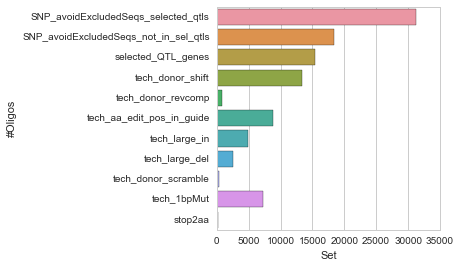

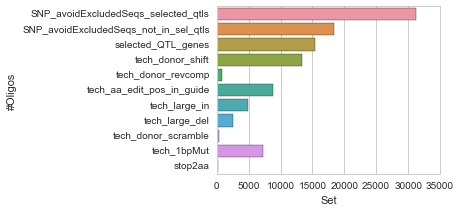

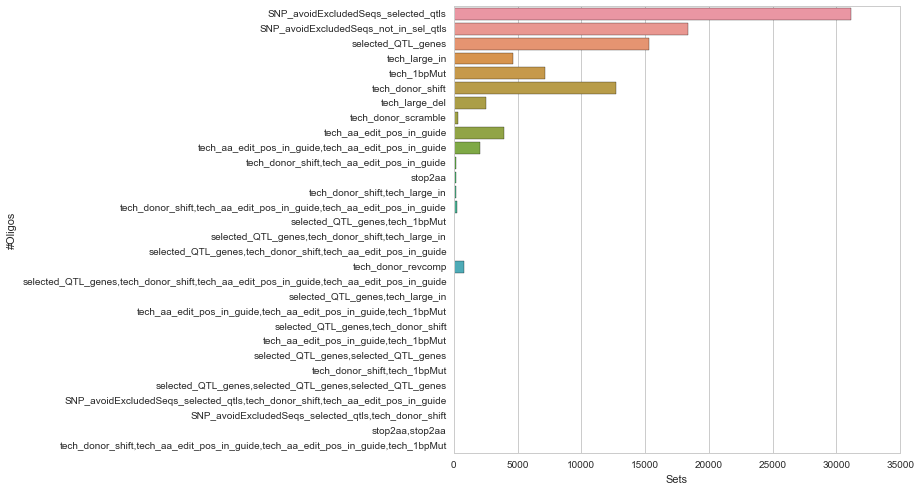

In [14]:
###############################################################################################################
# Drawign for the entire library
###############################################################################################################

print "-----------------------------------------------------------------------------------------------------------"
print "Description of CRISPR editing library: %s" % (output_files_uniq_str)
print "-----------------------------------------------------------------------------------------------------------"

print "# total non unique oligos: %d"% (non_uniq_oligo_df.shape[0])
print "# total  unique oligos: %d"% (uniq_oligo_df.shape[0])
print "Set sizes (non unique):"
print non_uniq_oligo_df['set_name'].value_counts()


oligo_sets_overlap_df = non_uniq_oligo_df.groupby("oligo_seq")[[ "set_name", "oligo_seq" ] ].apply(lambda x: "%s" % ','.join(x['set_name'])).to_frame("set_names")
oligo_sets_overlap_df['oligo_seq'] = oligo_sets_overlap_df.index

print "Set overlap sizes (unique):"
print oligo_sets_overlap_df['set_names'].value_counts()

#oligo_sets_overlap_df.to_csv("./debug_sets_overlap.tab", sep='\t', index = False)



# drawing all sets name as counts bar plot
with sns.axes_style("whitegrid"):
        fig = plt.figure(figsize=(4,4))
        ax = sns.countplot(data=non_uniq_oligo_df, y='set_name') #, hue='set_name'
        ax.set(xlabel='Set', ylabel='#Oligos')
        fig.savefig( output_snp_guides_fig_pref + '' +  'oligoSetSize' + '.png', bbox_inches='tight')

with sns.axes_style("whitegrid"):
        fig = plt.figure(figsize=(4,3))
        ax = sns.countplot(data=non_uniq_oligo_df, y='set_name') #, hue='set_name'
        ax.set(xlabel='Set', ylabel='#Oligos')
        fig.savefig( output_snp_guides_fig_pref + '' +  'oligoSetSize' + '.pdf', bbox_inches='tight')
        

with sns.axes_style("whitegrid"):
        fig = plt.figure(figsize=(8,8))
        ax = sns.countplot(data=oligo_sets_overlap_df, y='set_names') #, hue='set_name'
        ax.set(xlabel='Sets', ylabel='#Oligos')
        fig.savefig( output_snp_guides_fig_pref + '' +  'uniqOligoSetOverlap' + '.png', bbox_inches='tight')




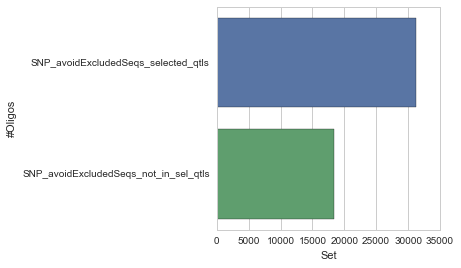

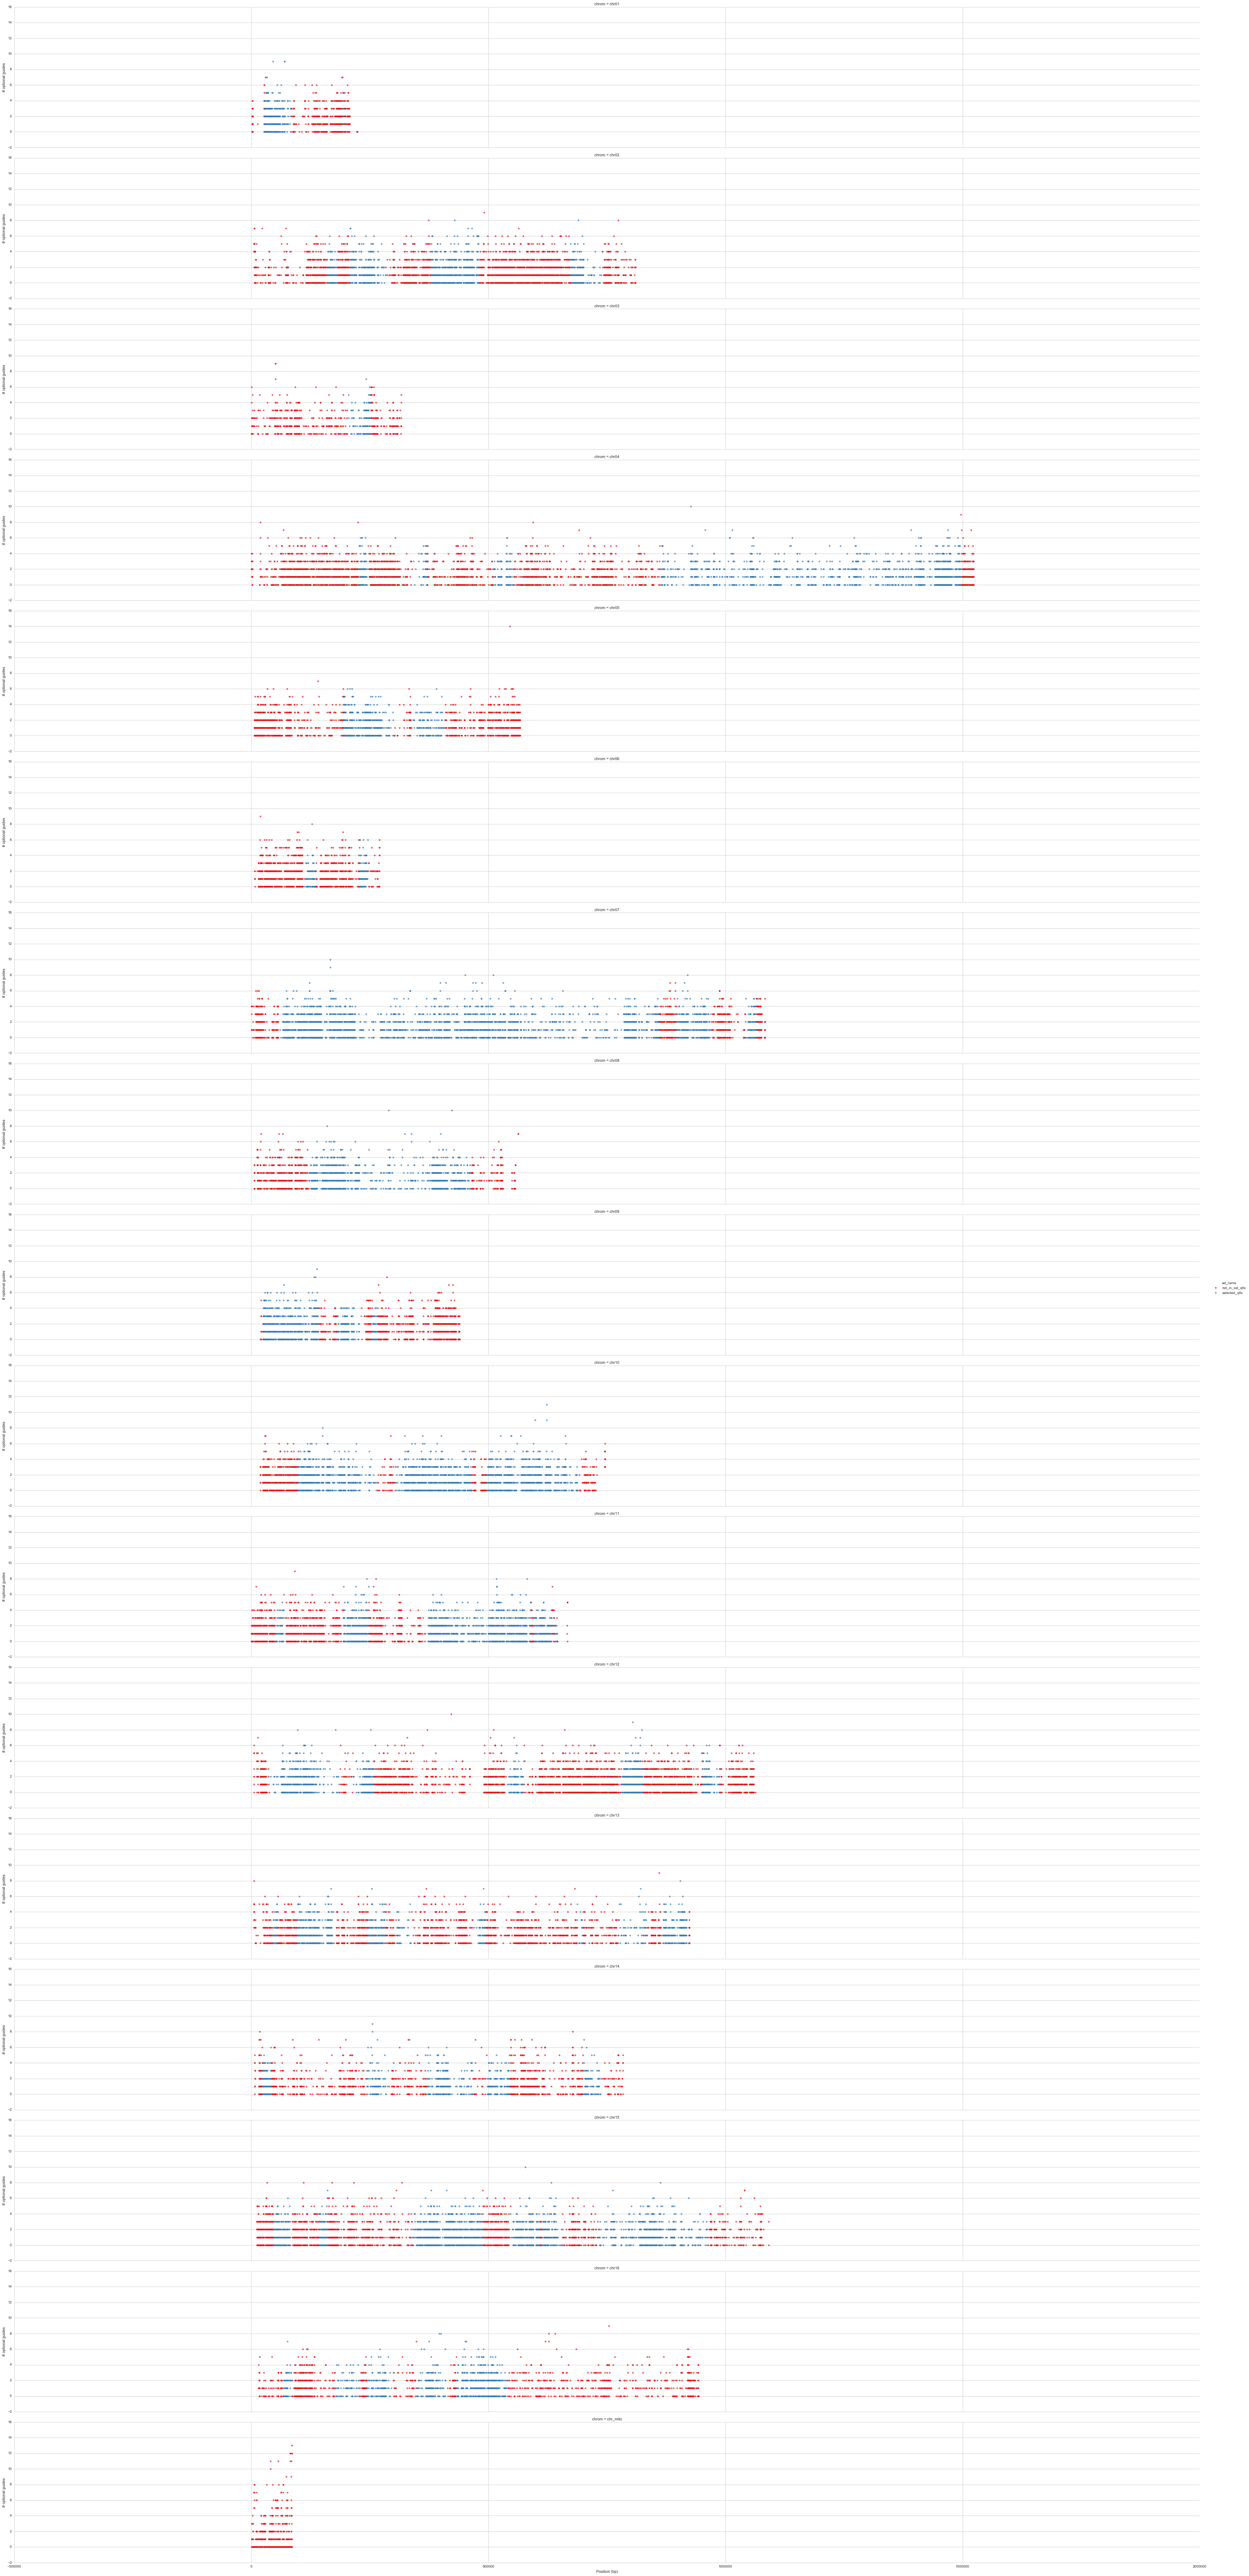

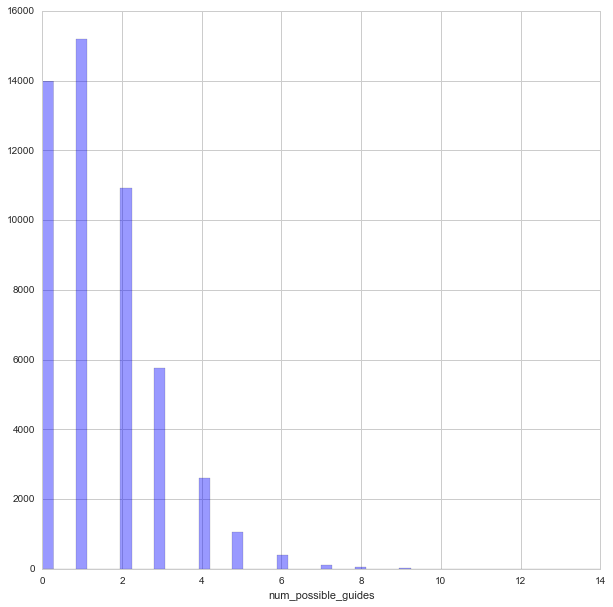

In [6]:
num_sel_oligos = snp_sel_OLIGO_df.shape[0]
num_sel_uniq_snpswith_oligos = len(snp_sel_OLIGO_df['SNP_id'].unique())

num_not_sel_oligos = snp_notSel_OLIGO_df.shape[0]
num_not_sel_uniq_snpswith_oligos = len(snp_notSel_OLIGO_df['SNP_id'].unique())


num_snps_in_sel_qtls =  snp_SNP_df['set_name'].value_counts()['selected_qtls']
num_snps_not_in_sel_qtls =  snp_SNP_df['set_name'].value_counts()['not_in_sel_qtls']

num_snp_oligos = snp_oligos.shape[0]

print "-------------------------- SNPs -------------------------------------------"
print ""
print "--- In selected QTLs:"
print "# oligos for SNPs in QTLs: %d"% (num_sel_oligos)
print "# SNPs in selected QTLs: %d" % (num_snps_in_sel_qtls)
print "# unique SNPs with oligos: %d" % (num_sel_uniq_snpswith_oligos)
print "%% SNPs in selected QTLs with oligos: %.2f%%" % (100 * (num_sel_uniq_snpswith_oligos/num_snps_in_sel_qtls))
print "# average oligos per SNP: %.2f" % ( (num_sel_oligos/num_sel_uniq_snpswith_oligos))
print ""
print "--- Not in selected QTLs:"
print "# oligos for SNPs not in QTLs: %d"% (num_not_sel_oligos)
print "# SNPs not in selected QTLs: %d" % (num_snps_not_in_sel_qtls)
print "# unique SNPs with oligos: %d" % (num_not_sel_uniq_snpswith_oligos)
print "%% SNPs not in selected QTLs with oligos: %.2f%%" % (100 * (num_not_sel_uniq_snpswith_oligos/num_snps_not_in_sel_qtls))
print "# average oligos per SNP: %.2f" % ( (num_not_sel_oligos/num_not_sel_uniq_snpswith_oligos))
print ""
print "--- Total:"
print "# oligos: %d"% (num_snp_oligos)

print "-------------------------- SNPs -------------------------------------------"

# drawing SNP set name as counts bar plot
with sns.axes_style("whitegrid"):
        fig = plt.figure(figsize=(4,4))
        ax = sns.countplot(data=snp_oligos, y='set_name') #, hue='set_name'
        ax.set(xlabel='Set', ylabel='#Oligos')
        fig.savefig( output_snp_guides_fig_pref + 'snp' +  '_oligoSetSize' + '.png', bbox_inches='tight')

# drawing SNPs # of guide and location on chromosomes         
with sns.axes_style("whitegrid"):
    fig = sns.FacetGrid(snp_SNP_df, row="chrom", hue="set_name", size=6, palette="Set1", aspect=8)
    fig.map(plt.scatter, "SNP_chr_pos", "num_possible_guides", alpha=.7)
    fig.set_axis_labels("Position (bp)", "# optional guides");
    fig.add_legend();
    fig.savefig( output_snp_guides_fig_pref + '' +  'SNPsInQTLsMap' + '.png', bbox_inches='tight')

    fig = plt.figure(figsize=(10,10))
    ax = sns.distplot(snp_SNP_df['num_possible_guides'], kde=False, color="b")
    fig.savefig( output_snp_guides_fig_pref + '' +  'NumOptionalGuidesPerSNP' + '.png', bbox_inches='tight')
    

In [7]:
print "-------------------------- Genes in QTLs ----------------------------------------"

print "Library: %s" % (output_files_uniq_str)
print ""
print "# genes in selected QTLs: %d" % (len(qtl_genes_design_df['gene_id'].unique()) )
print "# genes in selected QTLs with oligos: %d (%f)" % ( len(qtl_genes_oligos['Gene'].unique()), len(qtl_genes_oligos['Gene'].unique())/len(qtl_genes_design_df['gene_id'].unique())  )
print "# oligo targeting genes in selected QTLs: %d" % ( qtl_genes_oligos.shape[0] )
print "# guides targeting genes in selected QTLs: %d" % ( len(qtl_genes_oligos['guide_id'].unique()) )
print "# donors targeting genes in selected QTLs: %d" % ( len(qtl_genes_oligos['donor_id'].unique()) )
print "# guides per gene: %f" % (len(qtl_genes_oligos['guide_id'].unique()) / len(qtl_genes_oligos['Gene'].unique()) )
print "# oligos creating a nonsense mutation: %d" % ( len(qtl_genes_oligos['donor_id'][ (qtl_genes_oligos['donor_info_str'].str.startswith("nons") ).values].unique()) )
print "# oligos creating a insertion frameshift mutation: %d"% ( len(qtl_genes_oligos['donor_id'][ (qtl_genes_oligos['donor_info_str'].str.startswith("in") ).values].unique()) )


print "-------------------------- Genes in QTLs ----------------------------------------"

#print output_oligos_for_genes_in_selected_qtls_df_filename
#print qtl_genes_oligos.head(3)
#qtl_genes_design_df.head(3)


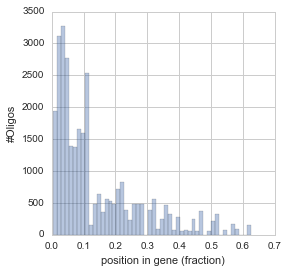

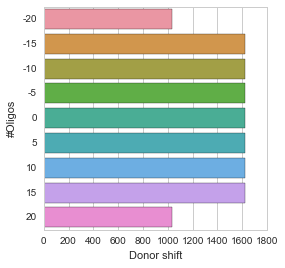

In [8]:
ess_genes_oligos["guide_cut_gene_pos_frac"] = ess_genes_oligos["guide_cut_gene_nt_pos"] / ess_genes_oligos["CDS_len_nts"]

print "-------------------------- guides and donor that target essential genes ----------------------------------------"

print "Library: %s" % (output_files_uniq_str)
print ""

print "# oligo targeting essential genes: %d" % ( ess_genes_oligos.shape[0] )

print "# oligo in sets: "
print ess_genes_oligos['set_name'].value_counts()


with sns.axes_style("whitegrid"):
        fig = plt.figure(figsize=(4,4))
        ax = sns.distplot(ess_genes_oligos['guide_cut_gene_pos_frac'], kde=False, rug=False);
        ax.set(xlabel='position in gene (fraction)', ylabel='#Oligos')
        fig.savefig( output_snp_guides_fig_pref + 'ess' +  '_posInGene' + '.png', bbox_inches='tight')


print ""
print "-------------- donor shift set:  ------------------"


tmp_ess_oligo_set = ess_genes_oligos[ ess_genes_oligos['set_name'] == 'tech_donor_shift']

with sns.axes_style("whitegrid"):
        fig = plt.figure(figsize=(4,4))
        ax = sns.countplot(data=tmp_ess_oligo_set, y='donor_seq_shift') #, hue='set_name'
        ax.set(xlabel='Donor shift', ylabel='#Oligos')
        fig.savefig( output_snp_guides_fig_pref + 'shift' +  '_oligoNum' + '.png', bbox_inches='tight')

#with sns.axes_style("whitegrid"):
#        fig = plt.figure(figsize=(4,4))
#        ax = sns.distplot(tmp_ess_oligo_set['donor_seq_shift'], kde=False, rug=False);
#        ax.set(xlabel='Donor shift', ylabel='#Oligos')
#        fig.savefig( output_snp_guides_fig_pref + 'shift' +  '_oligoNumHist' + '.png', bbox_inches='tight')

tmp_guides_gene_unique = tmp_ess_oligo_set[ ['Gene', 'guide_id'] ].drop_duplicates()

print "# guides per gene: "
print tmp_guides_gene_unique['Gene'].value_counts()


print "-------------------------- guides and donor that target essential genes ----------------------------------------"


print output_oligos_for_essential_genes_df_filename
#print ess_genes_oligos.head(5)



In [9]:
sys.stdout = org_stdout

print "========================================================="
print "========================================================="



In [19]:

a_df = non_uniq_oligo_df.copy()


def align_guide_and_donor(row):
    cur_align = pairwise2.align.localxs(row['guide_noPAM'],row['donor_seq'],-1,-1)
    if len(cur_align)>0:
        return(max(cur_align)[2])
    else:
        return(-1)
    
def align_revcomp_guide_and_donor(row):
    cur_align = pairwise2.align.localxs( str(Seq(row['guide_noPAM'],alphabet=generic_dna).reverse_complement())  ,row['donor_seq'],-1,-1)
    if len(cur_align)>0:
        return(max(cur_align)[2])
    else:
        return(-1)  

#align_guide_and_donor = lambda row: max(pairwise2.align.localxs(row['guide_noPAM'],row['donor_seq'],-1,-1))[2]
#align_revcomp_guide_and_donor = lambda row: max(pairwise2.align.localxs( str(Seq(row['guide_noPAM'],alphabet=generic_dna).reverse_complement())  ,row['donor_seq'],-1,-1))[2]

a_df['guide_donor_align_score'] = a_df.apply(align_guide_and_donor, axis=1)
a_df['revcomp_guide_donor_align_score'] = a_df.apply(align_revcomp_guide_and_donor, axis=1)

a_df['is_donor_and_guide_same_Strand'] = a_df['guide_donor_align_score'] >= a_df['revcomp_guide_donor_align_score']


print sum(a_df['is_donor_and_guide_same_Strand'].astype(bool) == True)
print sum(a_df['is_donor_and_guide_same_Strand'].astype(bool) == False)



99600
1169


In [37]:
print a_df['set_name'][(a_df['is_donor_and_guide_same_Strand'].astype(bool) == False).values].drop_duplicates()


print a_df[(a_df['is_donor_and_guide_same_Strand'].astype(bool) == False).values & (a_df['set_name'] == 'SNP_avoidExcludedSeqs_selected_qtls').values]


print a_df['guide_noPAM'][(a_df['is_donor_and_guide_same_Strand'].astype(bool) == False).values & (a_df['set_name'] == 'SNP_avoidExcludedSeqs_selected_qtls').values]

print a_df['donor_seq'][(a_df['is_donor_and_guide_same_Strand'].astype(bool) == False).values & (a_df['set_name'] == 'SNP_avoidExcludedSeqs_selected_qtls').values]

a_df[(a_df['is_donor_and_guide_same_Strand'].astype(bool) == False).values & (a_df['set_name'] == 'SNP_avoidExcludedSeqs_selected_qtls').values]


a_df[(a_df['is_donor_and_guide_same_Strand'].astype(bool) == True).values & (a_df['set_name'] == 'tech_donor_revcomp').values]
print '---'
a_df[ (a_df['set_name'] == 'tech_donor_scramble').values]



23008    SNP_avoidExcludedSeqs_selected_qtls
65067                     tech_donor_revcomp
65461                         tech_large_del
66616                    tech_donor_scramble
Name: set_name, dtype: object
                                  set_name     guide_id  \
23008  SNP_avoidExcludedSeqs_selected_qtls  guide_52969   

                                                donor_id  \
23008  guide_52969:REF2ALT:offset0:donorID52186:EditP...   

                                                oligo_id  donor_info_str  \
23008  SNP_avoidExcludedSeqs_selected_qtls#guide_5296...  ALT2REF:AATT>A   

                guide_noPAM  \
23008  CAGAAGAAGAAATTCCACCA   

                                               donor_seq  \
23008  TATGAGATGCTACTTTTCTCTCTTGCCTGTCCTTTCCAGAAGAAGA...   

                                               oligo_seq  \
23008  GAGTTACTGTCTGTTTTCCTTATGAGATGCTACTTTTCTCTCTTGC...   

       guide_donor_align_score  revcomp_guide_donor_align_score  \
23008                    

,set_name,guide_id,donor_id,oligo_id,donor_info_str,guide_noPAM,donor_seq,oligo_seq,guide_donor_align_score,revcomp_guide_donor_align_score,is_donor_and_guide_same_Strand
66594,tech_donor_scramble,YAL041W_pS_2_scramble,YAL041W_pS_2_scramble:synonymous:offset0:donor...,tech_donor_scramble#YAL041W_pS_2_scramble#YAL0...,synonymous:GTC>GTT:V>V:scramble,CAGTACTACGGTAATTAGCC,TCCCTAAGAACAACAGCAAGAGAATGCGAAGGTAACTCAACCACAC...,GAGTTACTGTCTGTTTTCCTTCCCTAAGAACAACAGCAAGAGAATG...,12.0,10.0,True
66595,tech_donor_scramble,YAL041W_pS_2_scramble,YAL041W_pS_2_scramble:synonymous:offset0:donor...,tech_donor_scramble#YAL041W_pS_2_scramble#YAL0...,synonymous:GTC>GTA:V>V:scramble,CAGTACTACGGTAATTAGCC,GACAGTCTCATCATGCTGGCTAATACTTACTCCAGAATTAGTCTGC...,GAGTTACTGTCTGTTTTCCTGACAGTCTCATCATGCTGGCTAATAC...,12.0,12.0,True
66596,tech_donor_scramble,YAL041W_pS_4_scramble,YAL041W_pS_4_scramble:synonymous:offset0:donor...,tech_donor_scramble#YAL041W_pS_4_scramble#YAL0...,synonymous:CAT>CAC:H>H:scramble,AAGCGATCCTCATCCAAAGC,GATTGGGCGAAATCTACGTAAGGACGTGAGTGCCGCAGCTTAGGCC...,GAGTTACTGTCTGTTTTCCTGATTGGGCGAAATCTACGTAAGGACG...,11.0,11.0,True
66597,tech_donor_scramble,YAL041W_pS_5_scramble,YAL041W_pS_5_scramble:synonymous:offset0:donor...,tech_donor_scramble#YAL041W_pS_5_scramble#YAL0...,synonymous:TCC>TCG:S>S:scramble,ACAACAGACTAGATGCGCTC,ACATAGGGAAGACACAATTGGGAGCTTCACACCCTTTATTTGAGAT...,GAGTTACTGTCTGTTTTCCTACATAGGGAAGACACAATTGGGAGCT...,11.0,11.0,True
66598,tech_donor_scramble,YAL041W_pS_5_scramble,YAL041W_pS_5_scramble:synonymous:offset0:donor...,tech_donor_scramble#YAL041W_pS_5_scramble#YAL0...,synonymous:TCC>AGC:S>S:scramble,ACAACAGACTAGATGCGCTC,TGGGATGTCTCTAGCCGACAGCTAAAACAGTCTCGATAAAACCCAC...,GAGTTACTGTCTGTTTTCCTTGGGATGTCTCTAGCCGACAGCTAAA...,12.0,10.0,True
66599,tech_donor_scramble,YAL041W_pS_5_scramble,YAL041W_pS_5_scramble:synonymous:offset0:donor...,tech_donor_scramble#YAL041W_pS_5_scramble#YAL0...,synonymous:TCC>TCT:S>S:scramble,ACAACAGACTAGATGCGCTC,AGCTAAGACTGTCCACGGTATAAGAAGCTTCGATAAATCGAGGCAG...,GAGTTACTGTCTGTTTTCCTAGCTAAGACTGTCCACGGTATAAGAA...,11.0,10.0,True
66600,tech_donor_scramble,YAL041W_mS_3_scramble,YAL041W_mS_3_scramble:synonymous:offset0:donor...,tech_donor_scramble#YAL041W_mS_3_scramble#YAL0...,synonymous:GGC>GGT:G>G:scramble,CTGGGTAATAAGAGCACGCT,CTACTAGCTAGTGCTTTGGTTATATTGTAAACGGACTGGGTCAATT...,GAGTTACTGTCTGTTTTCCTCTACTAGCTAGTGCTTTGGTTATATT...,12.0,11.0,True
66601,tech_donor_scramble,YAL041W_mS_3_scramble,YAL041W_mS_3_scramble:synonymous:offset0:donor...,tech_donor_scramble#YAL041W_mS_3_scramble#YAL0...,synonymous:GGC>GGG:G>G:scramble,CTGGGTAATAAGAGCACGCT,GATAAAGGGACGCTAATAACCTGTGATATTGTGGCTCACTTGAAAG...,GAGTTACTGTCTGTTTTCCTGATAAAGGGACGCTAATAACCTGTGA...,11.0,11.0,True
66602,tech_donor_scramble,YAL041W_mS_6_scramble,YAL041W_mS_6_scramble:synonymous:offset0:donor...,tech_donor_scramble#YAL041W_mS_6_scramble#YAL0...,synonymous:GCA>GCC:A>A:scramble,AACGTATAGGTACGATGGTG,ACAGTAACGGATAGCTTATATGCTTTGACAGTTCGGGTTGAAGCTG...,GAGTTACTGTCTGTTTTCCTACAGTAACGGATAGCTTATATGCTTT...,13.0,11.0,True
66603,tech_donor_scramble,YAL041W_mS_6_scramble,YAL041W_mS_6_scramble:synonymous:offset0:donor...,tech_donor_scramble#YAL041W_mS_6_scramble#YAL0...,synonymous:GCA>GCT:A>A:scramble,AACGTATAGGTACGATGGTG,TAAGCTTGTAAAGCGGTCGGTTCTTCCTTACAGAAACAGGGTGCTA...,GAGTTACTGTCTGTTTTCCTTAAGCTTGTAAAGCGGTCGGTTCTTC...,12.0,10.0,True


In [49]:
def align_guide_and_donor(row):
    cur_align = pairwise2.align.localxs(row['guide_noPAM'],row['donor_seq'],-1,-1)
    if len(cur_align)>0:
        return(max(cur_align)[2])
    else:
        return(-1)
    
def align_revcomp_guide_and_donor(row):
    cur_align = pairwise2.align.localxs( str(Seq(row['guide_noPAM'],alphabet=generic_dna).reverse_complement())  ,row['donor_seq'],-1,-1)
    #print cur_align
    if len(cur_align)>0:
        return(max(cur_align)[2])
    else:
        return(-1) 

indx = 18355
print a_df.ix[indx]


print a_df.ix[indx,'guide_noPAM']
print a_df.ix[indx,'donor_seq']
print align_guide_and_donor(a_df.ix[indx])
print align_revcomp_guide_and_donor(a_df.ix[indx])

set_name                        SNP_avoidExcludedSeqs_selected_qtls
guide_id                                                guide_41763
donor_id          guide_41763:REF2ALT:offset0:donorID41161:EditP...
oligo_id          SNP_avoidExcludedSeqs_selected_qtls#guide_4176...
donor_info_str                                          ALT2REF:C>T
guide_noPAM                                    AGAAGAAGAAAAGAAAAAGA
donor_seq         GAAGAAGGAAGAAGAGGAAAAGAAGAAGAAGGAAGAAGAAGAAAAG...
oligo_seq         GAGTTACTGTCTGTTTTCCTGAAGAAGGAAGAAGAGGAAAAGAAGA...
Name: 18355, dtype: object
AGAAGAAGAAAAGAAAAAGA
GAAGAAGGAAGAAGAGGAAAAGAAGAAGAAGGAAGAAGAAGAAAAGAAAAAGAAAGAAGAGGAAGAGAAGAAAAAGAAGGAAGAAGAAGAGAAGAAAAAG
20.0
-1


In [ ]:
import matplotlib_venn as ven

In [1]:

from Bio import SeqIO
from Bio.Seq import Seq
from Bio.Alphabet import generic_dna
import random
from Bio import pairwise2



In [38]:

b = Seq("GAAGAAGGAAGAAGAGGAAAAGAAGAAGAAGGAAGAAGAAGAAAAGAAAAAGAAAGAAGAGGAAGAGAAGAAAAAGAAGGAAGAAGAAGAGAAGAAAAAG", alphabet=generic_dna)
a = Seq("AGAAGAAGAAAAGAAAAAGA", alphabet=generic_dna)
c = Seq("TTGAAA", alphabet=generic_dna)
#alignments = pairwise2.align.globalxx(a, b)

from Bio.pairwise2 import format_alignment
#for a in pairwise2.align.globalxx(a,b):
#    print(format_alignment(*a))

x = pairwise2.align.localxs(a.reverse_complement(),b,-1,-1)

print a.reverse_complement()
print x
print len(x)
print max(x)[2]
print type(x[0])

#y = pairwise2.align.localxs(a,c,-1,-1)
#print y
#print max(y)[2]






TCTTTTTCTTTTCTTCTTCT
[]
0


ValueError: max() arg is an empty sequence